Alex Medina | Problem Set #3

**Problem 1**

- Reading light curve data associated with Kepler Object of Interest (KOI) 97
- Three arrays: time, flux and flux_err
    - Each observation is Coordinated Universal Time (UTC) - 2454833
- Plotting flux vs. time.

In [1]:
#Imports

import math as m
import numpy as np
import matplotlib.pyplot as plt

#Extra for this set
import pickle

In [2]:
#Since we're dealing with pickle structure
#Open for binary read

f97 = open("KOI97_01.p", "rb")
data97 = pickle.load(f97)
time, flux, flux_err = data97

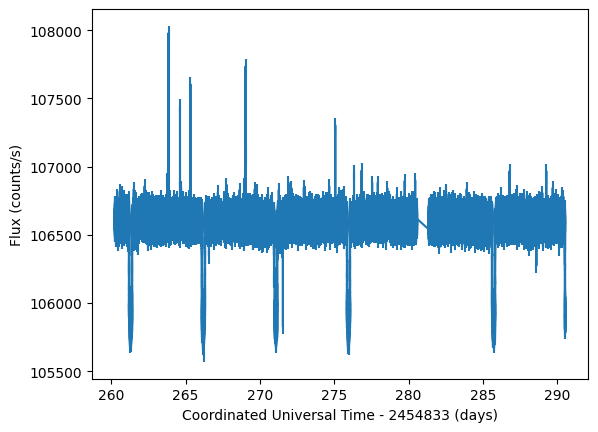

In [3]:
#Plotting with error bars
plt.errorbar(time, flux, yerr=flux_err)
plt.xlabel('Coordinated Universal Time - 2454833 (days)')
plt.ylabel("Flux (counts/s)")
plt.show()

**Problem 2**  

- Comparing observational data to a theoretical lightcurve.
- Beginning wit fitting to flux ratio code with uniform stellar intensity (estimating parameters by eye).
- Convert from time $t$ to $z$ with:

\begin{equation}
z(t) = \frac{(t - t_0)}{\tau}
\end{equation}

where $\tau$ and $t_0$ are constants: $\tau$ is related to the duration of the eclipse and $t_0$ is the time of maximal eclipse. Guess values for $p$, $\tau$, and $t_0$, and calculate $F(p, z(t))$. 

- Use more realistic limb-darkening function:

\begin{equation}
I(r) = 1 - (1 - \mu^{3/2})
\end{equation}

where

\begin{equation}
\mu = \cos\theta = \sqrt{1 - r^2}.
\end{equation}


In [4]:
#Creating the index, and using it to create new indicies containing just the data
#Using np.where

index = np.where((time > 261) & (time < 261.5))
time_obs = time[index]
flux_obs = flux[index]
flux_err_obs = flux_err[index]

<ErrorbarContainer object of 3 artists>

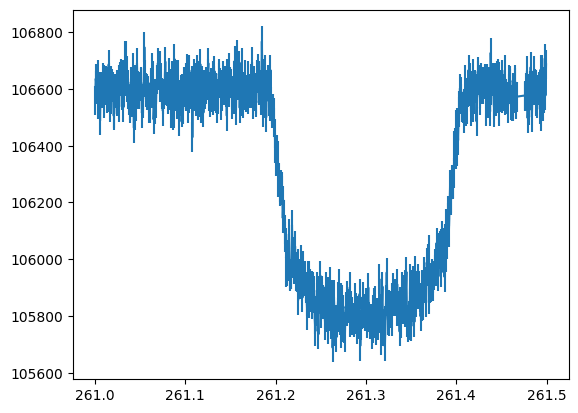

In [5]:
#To make sure it looks okay
plt.errorbar(time_obs, flux_obs, yerr=flux_err_obs)

In [6]:
#Ultimately, we normalize since our equations have normalized values
flux_normalization = flux_obs[0]
flux_normalized = flux_obs/flux_normalization
flux_normalized_err = flux_err_obs/flux_normalization

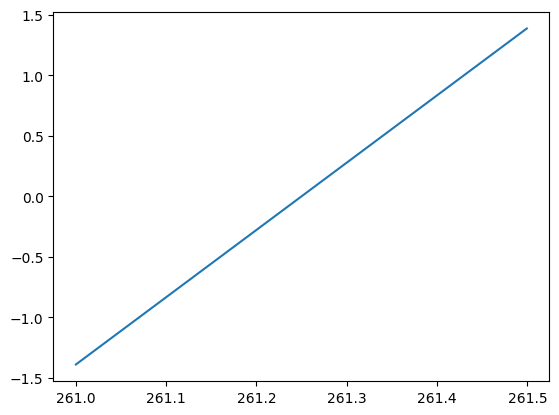

In [7]:
#For part (a); using values from pset1

p = 0.1
#After some trial and error, we need to get z approaches 1
tau = 0.18
t0 = 261.25
z = (time_obs-t0)/tau

plt.plot(time_obs,z)
plt.show()

In [8]:
#From pset 2 (really pset 1 but cleaned up in pset 2)

def lambda_fct(p, z):
    #Case when the planet is off of the star entirely
    if z > 1 + p:
        return 0

    #Case where the planet is bigger than the star (i.e. eclipse)
    elif z <= p - 1:   
        return 1

    #Case where the planet is entirely on the star 
    elif z <= 1 - p:   
        return p*p       
    
    #Now the big part is for partial obscuration
    elif (m.fabs(1 - p) < z) and (z <= (1 + p)):
        
        root = 0.5 * np.sqrt(4 * z**2 - (1 + z**2 - p**2)**2)
        k0 = (p**2 + z**2 - 1) / (2 * p * z)  
        k1 = (1 - p**2 + z**2) / (2 * z)  
        kappa_0  = m.acos(k0)
        kappa_1  = m.acos(k1)
        
        #print(sqrt_fact, kappa_0, kappa_1)
        return (1 / m.pi) * (p**2 * kappa_0 + kappa_1 - root)

#original flux from problem set 1 for an error analysis
def og_flux(p, z):
    return 1 - lambda_fct(0.2, np.abs(z))

In [9]:
#Looping over the predicted flux

flux_predicted = []
for zval in z:
    flux_predicted.append(og_flux(p, zval))

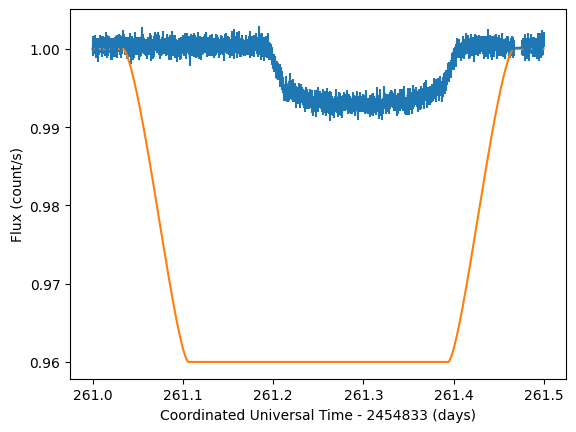

In [10]:
plt.errorbar(time_obs, flux_normalized, yerr=2*flux_normalized_err)
plt.plot(time_obs, flux_predicted)
plt.xlabel("Coordinated Universal Time - 2454833 (days)")
plt.ylabel("Flux (count/s)")
plt.show()

Doesn't look great, but we can refine it by messing aorun with the p, tau and t0 values

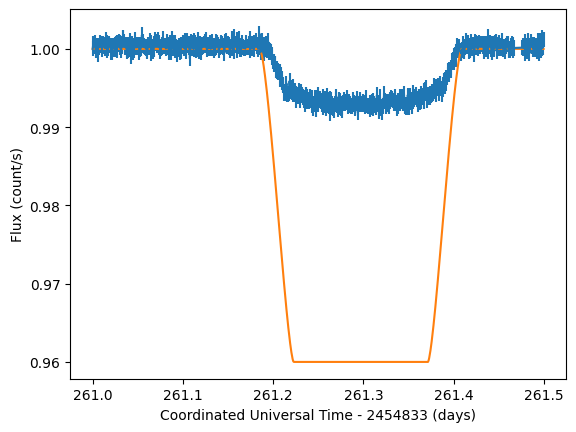

In [11]:
p = 0.084
tau = 0.093
t0 = 261.297
z = (time_obs-t0)/tau

flux_predicted = []
for zval in z:
    flux_predicted.append(og_flux(p, zval))
    
plt.errorbar(time_obs, flux_normalized, yerr=2*flux_normalized_err)
plt.plot(time_obs, flux_predicted)
plt.xlabel("Coordinated Universal Time - 2454833 (days)")
plt.ylabel("Flux (count/s)")
plt.show()

Looks good! Now, using a more realistic limb darkening function from pset 2.

In [12]:
def simpson_int(fct, a, b, N):
    #Goes as (1/6 f0 + 2/3 f0.5 + 1/3 f1 + 2/3 f1.5 +... + 1/6 fn)
    #with fct, a, b, and N representing the same things, just the result changes
    delx = (b - a) / N   #rectangle width
    
    result = 0
    for i in np.arange(N):
        x       = a + i * delx
        result += (fct(x) + 4 * fct(x + 0.5 * delx) + fct(x + delx)) / 6 * delx   
    return result

def physical_limb(r):
    mu = np.sqrt(1 - r**2)   #cos theta
    return 1 - (1 - mu**1.5)

def delta_fct(p, r, z):
    if (r >= z + p) or (r <= z - p):
        return 0
    elif (r + z <= p):
        return 1
    else:
        #Learning to prevent errors
        if (z != 0) and (r != 0): #prevent div by zero errors
            arg = (z**2 - p**2 + r**2) / (2 * z * r)
        else:
            print('Either z or r vanished. z =',z,'; and r =',r,'.')
        return (1/np.pi) * np.arccos(arg)

def new_flux(p, z, limb_fct, integrator, N):
    #Note this KEY difference
    #We have to use z as an absolute value becasue otherwise we only get have of the elipse

    z = np.abs(z)

    def numerator(r, p = p, z = z):
        return limb_fct(r) * (1 - delta_fct(p, r, z)) * 2 * r
    def denominator(r):
        return limb_fct(r) * 2.0 * r
    
    #Bounds
    lower = 0
    upper = 1
    
    top = integrator(numerator, lower, upper, N)
    bottom = integrator(denominator, lower, upper, N)

    return top/bottom

In [13]:
p = 0.084
tau = 0.093
t0 = 261.297
z = (time_obs-t0)/tau

flux_predicted = []
for zval in z:
    flux_predicted.append(new_flux(p, zval, physical_limb, simpson_int, 1000))

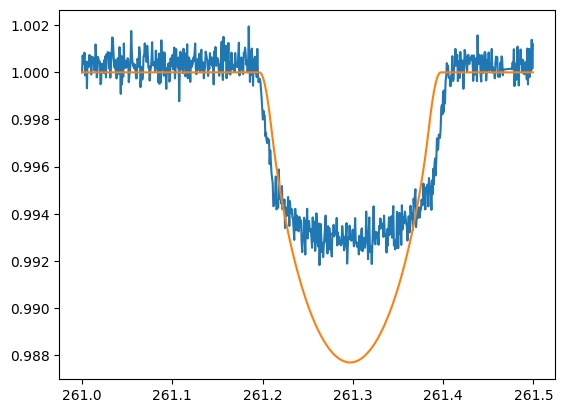

In [14]:
#Plotting with a more realisitc limb darkening fct
plt.plot(time_obs, flux_normalized)
plt.plot(time_obs, flux_predicted)
plt.show()

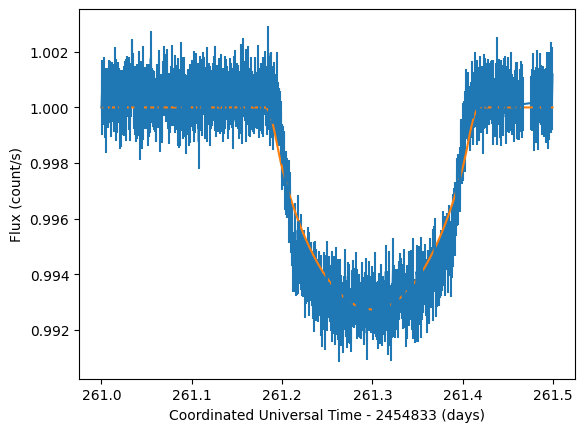

In [ ]:
#Adjusting the p and z values a little bit more
p = 0.0645
tau = 0.112
t0 = 261.3
z = (time_obs-t0)/tau

flux_predicted = []
for zval in z:
    flux_predicted.append(new_flux(p, zval, physical_limb, simpson_int, 1000))

#Including the error bar
plt.errorbar(time_obs, flux_normalized, yerr=2*flux_normalized_err)
plt.plot(time_obs, flux_predicted)
plt.xlabel("Coordinated Universal Time - 2454833 (days)")
plt.ylabel("Flux (count/s)")
plt.show()

**Problem 3:**

- A theoretical determination of the habitable zone range is given in Kopparapu et al.  where the inner edge of the habitable zone is:

\begin{equation}
d = \left( \frac{L/ L_*}{S_e} \right)^{1/2} \text{ AU},
\end{equation}

where $L/L_* = \left( \frac{T_e}{5780\, \text{K}} \right)^4 $ is the luminosity of the star in terms of its effective temperature $T_{eff}$, and $S_{eff}$ is given approximately by:

\begin{equation}
S_{eff} = S_{eff, *} + aT_* + b T_* ^2
\end{equation}

with $T_* = T_{eff} - 5780 K $.

- For the inner edge of the habitable zone, $S_{eff, *} = 1.014$, $a = 8.177 \times 10^{-5}$, and $b = 1.706 \times 10^{-9}$.
- Create a root finder to determine $T_{eff}$ for a radius of $d = 0.5 \text{AU}$ (i.e., find $T_{eff}$ for which $f(T_{eff}) = d(T_{eff}) - 0.5 \text{AU} = 0$).


In [16]:
#Creating the root finder that depends on a function
#Using the secant method

def root_secant(fct, a, b, tol):
    #tol is the tolerance
    #doing at most 100 iterations
    for i in range(100):
        deltax = (b - a) * fct(b) / (fct(b) - fct(a))
        a = b
        b = b - deltax
        if abs(deltax) < tol:
            print("iterations:",i)
            return b
    raise ArithmeticError("root finding failed")

In [ ]:
#Creating a root finder with the bisection method

def root_bisect(fct, a, b, tol):

    if (fct(a) * fct(b) >= 0):
        raise ValueError("Root not bracketed")
    i = 0 
    while (b - a) > tol:
        mid = (a + b) / 2
        i += 1
        if fct(mid) * fct(b) < 0:
            a = mid
        else:
            b = mid
    print("iterations:",i)
    return mid

In [18]:
#Functions for the problems

def seff(teff):
    tstar = teff - 5780.0
    return 1.014 + 8.177e-5 * tstar + 1.706e-9 * tstar**2
    
def hab_zone(teff):
    lum = (teff/5780.0)**4
    return np.sqrt(lum / seff(teff)) - 0.5

In [19]:
#Execute
root_bisect(hab_zone, 1, 1.0e4, 1.0e-5)

iterations: 30


3947.0646194992587

In [20]:
#Execute
root_secant(hab_zone, 1, 1.0e4, 1.0e-5)

iterations: 7


np.float64(3947.064625770776)

A star with a temperature of $T_{eff} of 3950 K.